# Chapter 7: Cross-Correlations, Fourier Transform, and Wavelet Transform

Gaining a deeper undersanding of causality, we look at time series forecasting through another lens.

In this chapter, we will take a different approach to how we analzye time series that is complementary to forecasting. Previously, methods of explaining such as the Granger Causality, S-mapping, and Cross-mapping, focused on the time domain - the values of the time series when measured over time or in its phase space. While both are useful for many tasks, it can be often useful to transform these time domain measurements to unearth patterns which are difficult to tease out. Specifically, we want to look at the frequency domain to both analyze the dynamics and perform pre-processing techniques that may be used to modify real-world datasets.

We will be analyzing the dynamics of time series not exactly to make forecasts, but to understand them in terms of their frequencies in complement to the previous methods of causality and explainability presented.

We introduce three techniques:

    1) Cross-correlations

    2) Fourier Transform

    3) Wavelet Transform

and test their use on the Jena Climate Dataset (2009-2016) along with a handful of other datasets.

The contents of this notebook are complied from the following references:

 -  Chapters 1-3 of Priestley, M.B. (1981). Spectral Analysis and Time Series, Vols. 1 and 2, Academic Press, New York.

 - <a href='https://towardsdatascience.com/multiple-time-series-classification-by-using-continuous-wavelet-transformation-d29df97c0442'>Multiple Time Series Classification by Using Continuous Wavelet Transformation</a>
 
 - <a href='https://pywavelets.readthedocs.io/en/latest/'>PyWavelets Documentation</a>


Prepared by: Gilbert Michael Go Chua

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import date, timedelta
import scipy as scp
import random
from statsmodels.tsa.stattools import adfuller
from itertools import repeat
import pywt
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if type(datax) != type(pd.DataFrame()) and type(datay) != type(pd.DataFrame()):
        datax = pd.Series(datax)
        datay = pd.Series(datay)
#     print(lag, end='\r')
    if wrap and lag != 0:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

## Cross-correlation Between Two Signals

Cross-correlation was discussed previously in the chapter on `Vector Autoregressive Methods` in a more strict statistical light. This time, we will be using a slightly modified definition more apt for signals. 

The cross-correlation between two signals $X_{1}$ and $X_{2}$ is given by:

\begin{align} R_{2,1}(s) = E[(X_{1,t}-\mu_{1})*(X_{2,t+s}-\mu_{2})] \end{align}


which is essentially the expected value of the <a href='https://en.wikipedia.org/wiki/Convolution'>convolution</a> between the covariance of two signals $X_{1}$ and $X_{2}$.

The normalized version is given by:

\begin{align} \rho_{21}(s) = \frac{R_{2,1}(s)}{(R_{1,1}(0)R_{2,2}(0))^{\frac{1}{2}}}\end{align}

The cross-correlation gives us the similarity of two time series at a given time lag $s$. By "sliding" $s$, we can find the correlation between two time series for all possible values of $s$.

$\rho_{2,1}(s)$ can be interpreted as the regular Pearson correlation at the specific lag $s$ with:

- A value of 1 having $X_{1}(t)$ and $X_{2}(t)$ being perfectly linearly correlated
- A value of 0 having $X_{1}(t)$ and $X_{2}(t)$ having no linear correlation with one another
- A value of -1 having $X_{1}(t)$ and $X_{2}(t)$ being perfectly negative linearly correlated

### Noisy Signals

To demonstrate this, we take the case of two simple yet noisy time series.

We want to measure the shift between two periodic signals Two sine waves are generated that are identical in both amplitude and frequency but one is shifted forward in time. By taking the maximum of the cross-correlation, we should be able to retrieve how much one of the time series leads (or lags!) the other.

In [3]:
def sine_wave(amp=1, freq=1, sample_rate=200, duration=5, plot=True,shift=0,
             noise=0):
    x = np.linspace(0, duration,sample_rate*duration)
    frequencies = x * freq
    y = np.sin(((2 * np.pi) * frequencies + shift)*(amp) + noise)
    if plot:
        plt.subplots(figsize=(15,2))
        plt.plot(x,y)
        plt.show()
    return x, y

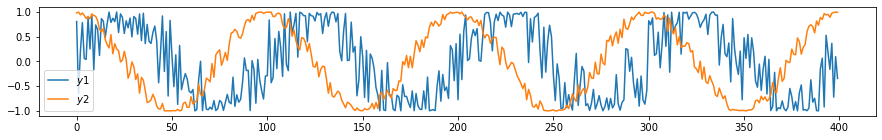

In [4]:
samp_rate = 100# Sampling Frequency in Hertz
dur = 4  # Duration in Seconds

amp1 = 1 #Amplitude of Sine Wave 1
freq1 = 1 #Frequency of Sine Wave 1

amp2 = 1 #Amplitude of Sine Wave 2
freq2 = 1 #Frequency of Sine Wave 2

phase_shift = np.pi/2 #Phase shift of 45 degress or equivalent to 25 samples
noise = np.random.uniform(-1,1,samp_rate*dur)
x1, y1 = sine_wave(amp1, freq1, samp_rate, dur,noise=noise,plot=False)
noise = np.random.uniform(-0.25,0.25,samp_rate*dur)
x2, y2 = sine_wave(amp2, freq2, samp_rate, dur,shift=phase_shift,noise=noise,plot=False)

plt.subplots(figsize=(15,2))
plt.plot(y1, label='$y1$')
plt.plot(y2, label='$y2$')
plt.legend();

By measuring the cross-correlation between these two signals we can find how far apart we should slide them ($s$) such that their linear relationship is maximized or minimized. 

Maximum correlation at 25
Minimum correlation at 74


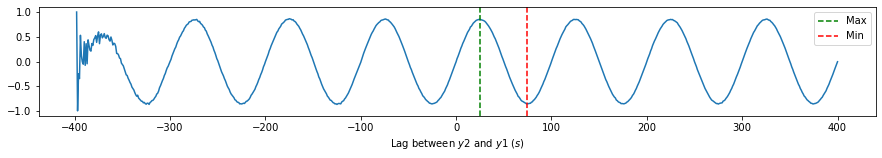

In [5]:
plt.subplots(figsize=(15,2))
ccor = [crosscorr(y1,y2, lag,wrap=True) for lag in range(-int(dur*samp_rate),int(dur*samp_rate+1))]
lags = np.arange(-samp_rate*dur, samp_rate*dur+1)
plt.plot(lags,ccor)

shift_0 = len(ccor)//2
max_ind = np.argmax(ccor[shift_0:shift_0+samp_rate])
min_ind = np.argmin(ccor[shift_0:shift_0+samp_rate])
plt.axvline(x=max_ind ,c='g',ls='--',label='Max')
plt.axvline(x=min_ind ,c='r',ls='--',label='Min')

plt.xlabel('Lag between $y2$ and $y1$ ($s$)')
plt.legend()
print('Maximum correlation at',lags[max_ind]+shift_0)
print('Minimum correlation at',lags[min_ind]+shift_0);

We find that the maximum correlation between $y_2$ and $y_1$ occurs at 27 samples. This is very close to the theoretical value of 25 samples corresponding to a phase shift of $\frac{\pi}{2}$ for a signal with 100 samples. Using only direct measurements from the data, albeit synthetic, we are able to retrieve a reasonable estimate of the lag and delay between them.

### Jena Climate Data

Let us look at how cross-correlations can be used to unearth relationships in real data. We will again use the Jena Climate Dataset to analyze the average temperature. This time, we will look at the relationship between daily temperature and daily wind speed.

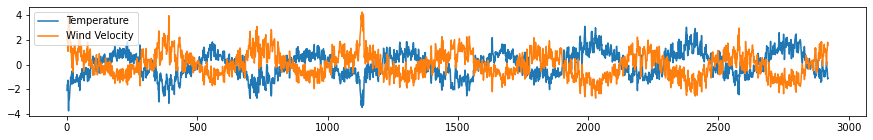

In [6]:
df = pd.read_csv('../data/jena_climate_2009_2016.csv')
data = df.iloc[:, 1:].astype(float).to_numpy()
temp = data[:, 1][::144]  #Temperature (in degrees Celsius) at one sample/day
wind = data[:,10][::144]  #Wind Speed (in m/s) at one sample/day

plt.subplots(figsize=(15,2))
plt.plot(range(len(temp)), (temp-np.mean(temp))/np.std(temp),label='Temperature')
plt.plot(range(len(wind)), (wind-np.mean(wind))/np.std(wind),label='Wind Velocity')
plt.legend();

As standard procedure in using correlation functions, we test for the stationarity of both time series.

In [7]:
result = adfuller(temp)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.937401
p-value: 0.001776
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [8]:
result = adfuller(wind)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.914097
p-value: 0.001934
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Given that the ADF statistics for both the temperature and wind measurements are more negative than the critical value for a 1% confidence interval, we reject the null hypothesis that there is a unit root in both series and adopt the alternative hypothesis that both series are stationary. We then proceed to perform the cross-correlation on the two series.

Maximum correlation at 178
Minimum correlation at 0


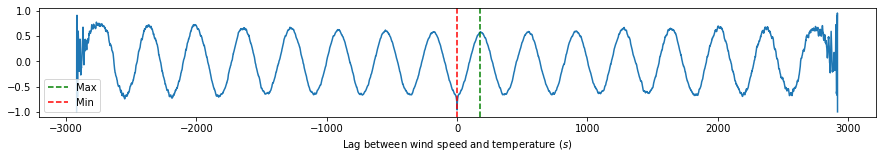

In [9]:
samp_rate = 1 # Sampling Frequency in Days
dur = len(temp)  # Duration in Days

plt.subplots(figsize=(15,2))
temp = pd.Series(temp)
wind = pd.Series(wind)
ccor = [crosscorr(temp,wind, lag) for lag in range(-int(dur*samp_rate),
                                                   int(dur*samp_rate+1))]
lags = np.arange(-samp_rate*dur, samp_rate*dur+1)
plt.plot(lags,ccor)

shift_0 = len(ccor)//2
max_ind = np.argmax(ccor[shift_0:shift_0+365])
min_ind = np.argmin(ccor[shift_0:shift_0+365])
plt.axvline(x=max_ind ,c='g',ls='--',label='Max')
plt.axvline(x=min_ind ,c='r',ls='--',label='Min')
plt.xlabel('Lag between wind speed and temperature ($s$)')
plt.legend()
print('Maximum correlation at',lags[max_ind]+shift_0)
print('Minimum correlation at',lags[min_ind]+shift_0);

We find that the shift maximizing the correlation between the daily values of temeperature and wind speed are 178 samples. An interesting result is that the correlation at $s=0$ is at a minimum. Both of these suggest that temperature and wind speed are periodic functions mirror each other in that when one is maximized, the other is minimized. We estimate then that the wind speed leads the temperature values by 178 days. 

It should be noted that unlike Granger Causality which also draws relationships between multiple time series, cross-correlation does not provide us with the causality between the two. At best, cross-correlation shows the synchronocity between two time series.

### Precipitation and Stream Flow

We apply cross-correlation analysis on the stream flow of a river and the precipitation in the surrounding area. 

To safely control the elecricity output of a run-of-the-river hydro-electric generator, operators must understand the relationship between the time it takes for rainfall to directly affect the stream's flow.

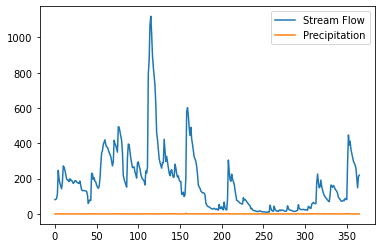

In [10]:
flow_df = pd.read_csv('../data/cc/flowsud_2000.txt',sep='\t')
flow_df.columns = ['USGS','site_no','datetime','flow','-']
flow_df['flow'].plot(label='Stream Flow')
rain_df = pd.read_csv('../data/cc/weather_2000.txt')
rain_df['Prcp'] = rain_df['Prcp'].replace('T',0.0005).astype(float)
rain_df['Prcp'].plot(label='Precipitation')
plt.legend();

In [11]:
rain = rain_df['Prcp']
flow = flow_df['flow']

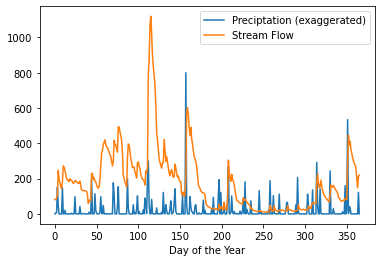

In [12]:
plt.plot(200*rain,label='Preciptation (exaggerated)')
plt.plot(flow,label='Stream Flow')
plt.xlabel('Day of the Year')
plt.legend();

We perform the Augmented Dickey-Fuller test on the two time series to figure out if they are stationary. If they are indeed stationary, we can proceed to performing the cross-correlation.

In [13]:
result = adfuller(flow)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.878838
p-value: 0.002196
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571


In [14]:
result = adfuller(rain)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -18.494992
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


Both time series are stationary and we proceed with the cross-correlation.

Maximum correlation at 1
Minimum correlation at 26


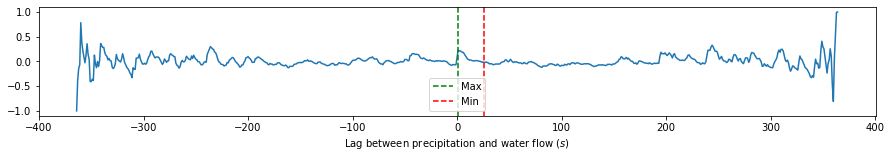

In [15]:
samp_rate = 1 # Sampling Frequency in Days
dur = len(flow)  # Total Duration in Days

plt.subplots(figsize=(15,2))
temp = pd.Series(temp)
wind = pd.Series(wind)
ccor = [crosscorr(flow,rain, lag) for lag in range(-int(dur*samp_rate),
                                                   int(dur*samp_rate+1))]
lags = np.arange(-samp_rate*dur, samp_rate*dur+1)
plt.plot(lags,ccor)

shift_0 = len(ccor)//2
max_ind = np.argmax(ccor[shift_0:shift_0+30])
min_ind = np.argmin(ccor[shift_0:shift_0+30])
plt.axvline(x=max_ind ,c='g',ls='--',label='Max')
plt.axvline(x=min_ind ,c='r',ls='--',label='Min')
plt.xlabel('Lag between precipitation and water flow ($s$)')
plt.legend()
print('Maximum correlation at',lags[max_ind]+shift_0)
print('Minimum correlation at',lags[min_ind]+shift_0);

We find that the maximum correlation happens when precipitation leads water flow by 1 day. While cross-correlation alone cannot give us causality, understanding of the measurements involved can be used to argue such. In the case of rainfall and precipitation, there is established understanding that precipitation leads to increases in river flow. We can conclude with some confidence that precipitation will cause an increase in river flow after 1 day.

To supplement our analysis, we move into the frequency domain with the Fourier Transform by first understanding the Fourier Series.

## The Fourier Series:

Any periodic signal can be broken down into a summation of sine and cosine waves. A periodic time series $X(t)$ can be broken down into fundamental frequencies given by the Fourier Series:

$\begin{align} X(t) = \frac{a_0}{2}  + \sum_{n=1}^{\infty}{a_n cos(nt)) + b_n sin(nt)} \end{align}$

Integrating both sides by $\int+{-\pi}^{\pi} cos(mt)dt$ where $m$ is an integer:

$\begin{align} \int_{-\pi}^{\pi}{X(t)cos(mt)dt} = \frac{1}{2} a_0 + \sum_{n=1}^{\infty}{\int_{-\pi}^{\pi}a_n cos(nt)cos(mt)dt + \sum_{n=1}^{\infty}\int_{-\pi}^{\pi}b_n sin(nt) cos(mt)dt} \end{align}$

Via orthogonality between $cos$ and $sin$ over $[-\pi,\pi]$:

$\begin{align} \int_{-\pi}^{\pi}{cos(nt)cos(mt)dt} = 0,   m\neq n \end{align}$
$\begin{align} \int_{-\pi}^{\pi}{sin(nt)cos(mt)dt} = 0,   all m,n \end{align}$
$\begin{align} \int_{-\pi}^{\pi}{cos(nt)sin(mt)dt} = 0,   m\neq n \end{align}$

Equation 4 reduces to:

$\begin{align} \int_{-\pi}^{\pi}{X(t)cos(mt)dt} = a_m \int_{-\pi}^{\pi}cos^{2}(mt)dt \end{align}$

Solving for this a_m, we find that:

$\begin{align} a_m = \frac{1}{\pi}\int_{-\pi}^{\pi}{X(t) cos(mt)dt} \end{align}$

Doing the same for b_m, we find the similar coefficient:

$\begin{align} b_m = \frac{1}{\pi}\int_{-\pi}^{\pi}{X(t) sin(mt)dt} \end{align}$

for $n =0,1,2...,$ where:

$n = 0$ is the constant component of the signal

$n = 1$ is the \textit{fundamental} corresponding to a sine/cosine wave whose period matches $X(t)$'s period exactly

$n = 2$ is the first harmonic corresponding to a sine/cosine whose period matches $\frac{1}{2}$ of $X(t)$'s period

$n = 3$ is the second harmonic corresponding to a sine/cosine whose period matches $\frac{1}{3}$ of $X(t)$'s period


One useful quantity to look at is the energy of a signal as it tells us how "much" of a signal there is. As the time domain and the frequency domain are just representing the same signal, then the total energy for both must be the same (Parseval's Relation). We define a single coefficient $c_n$ to describe the "energy" of a signal at a specific frequency:

$\begin{align}c_0 = \frac{a_0}{2}\end{align}$

$\begin{align}c_n = [\frac{1}{2}(a^2_n + b^2_n)]^{\frac{1}{2}}\end{align}$


## The Fourier Transform:

Transforming a signal in the time domain into the frequency ($\omega$) domain using this method is called the \textbf{Fourier Transform (FT)} given by:

\begin{align} \hat{X}(\omega) = \int_{-\infty}^{\infty}{X(t)e^{-2\pi i \omega t}d\omega} \end{align}

To better understand the FT, let us take a look at some of its applications.

### Pure Signal

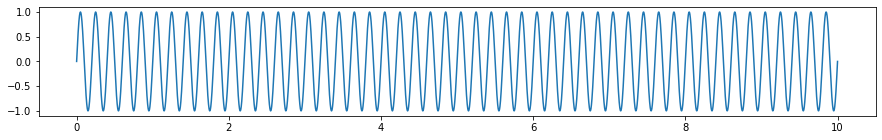

In [16]:
samp_rate = 1000 # Sampling Frequency in Hertz
dur = 10  # Duration in Seconds
amp = 1 #Amplitude of Sine Wave
freq = 5 #Frequency of Sine Wave
x, y = sine_wave(amp, freq, samp_rate, dur, plot=True)

Let's work with ideal conditions first. Let's apply the Fourier Transform on the single sine wave with frequency of 5 Hz.

Peak at: 5.0 Hz


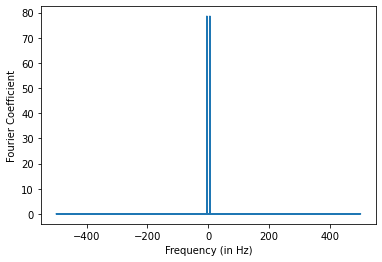

In [17]:
y_ft = scp.fft.fft(y)
freqs = scp.fft.fftfreq(x.shape[-1])*samp_rate
plt.plot(freqs, abs(y_ft.real))
plt.ylabel('Fourier Coefficient')
plt.xlabel('Frequency (in Hz)')
print('Peak at:',np.argmax(y_ft.real)/dur, 'Hz');

We see two peaks when the frequency is 5 and -5.

The left-hand side corresponds to negative frequencies. Physically, negative frequencies are not very meaningful but their presence is important in calculating for the Fourier Transform.

By finding the peaks of the "energy" (coefficient), we can find what frequency is most prevalent.

Additionally, the FT is a perfectly (to numerical precision) reversible process. This means that from just the Fourier coefficients, we can retrieve the original signal by performing an \textbf{Inverse Fourier Transform (IFT)}.

Is close: True


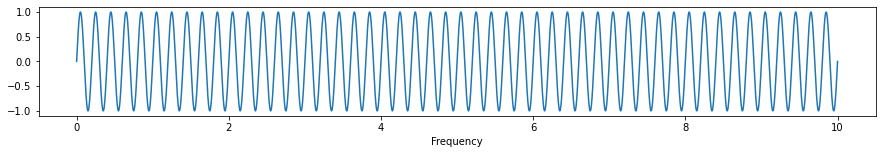

In [18]:
plt.subplots(figsize=(15,2))
plt.plot(x,scp.fft.ifft(y_ft).real)
plt.xlabel('Frequency')
print("Is close:",np.allclose(scp.fft.ifft(y_ft), y));

### Mixed Signals

An important use of the FT is analyzing signals with mixed frequencies. We can perform the above exercise on 2 combined waves (or even an arbitrary number of waves with differing frequencies!) to find which frequencies are present in our signal.

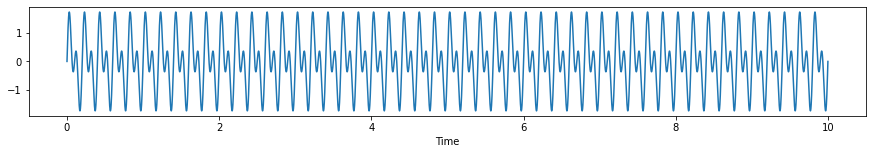

In [19]:
samp_rate = 1000 # Sampling Frequency in Hertz
dur = 10  # Duration in Seconds

amp1 = 1 #Amplitude of Sine Wave 1
freq1 = 5 #Frequency of Sine Wave 1

amp2 = 1 #Amplitude of Sine Wave 2
freq2 = 10 #Frequency of Sine Wave 2

x1, y1 = sine_wave(amp1, freq1, samp_rate, dur,plot=False)
x2, y2 = sine_wave(amp2, freq2, samp_rate, dur,plot=False)
y = y1 + y2 #Simply overlapping the two signals
plt.subplots(figsize=(15,2))
plt.xlabel('Time')
plt.plot(x1,y);

Eyeballing the graph, it is challenging to determine its exact frequency make up.

Peaks at: [ 5. 10.]


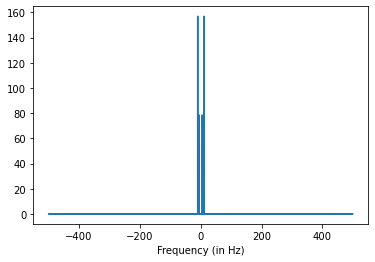

In [20]:
y_ft = scp.fft.fft(y)
freqs = scp.fft.fftfreq(x1.shape[-1])*samp_rate
plt.plot(freqs, abs(y_ft.real))
plt.xlabel('Frequency (in Hz)')
peaks=scp.signal.find_peaks(y_ft.real)
peak_vals = peaks[0][:len(peaks[0])//2]/dur
print('Peaks at:',peak_vals)

The FT makes it very easy to find the frequencies of the signal!

### Quick exploration:

    1. What do the heights of the peaks mean?
        Hint: Play with the amplitudes and frequencies.
        
    2. What happens when your frequency is higher than the sampling rate?
        Hint: Nyquist frequency.
    
    3. What are the implications of 1. and 2. these when measuring or collecting data?

## Frequency Domain Manipulation

One of the more common uses of FT besides is its ability to let us manipulate time series in the frequency domain.

To demonstrate this, we take the mixed signal from the previous example and add a constant term to it.
We want to retrieve the original signal as that is where the interesting behavior lies.

*(not unlike a DC signal on top of an AC signal)*

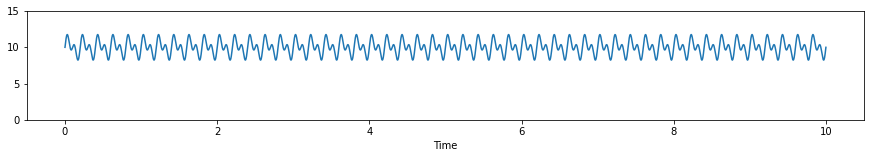

In [21]:
dc = 10
y_dc = y+dc
plt.subplots(figsize=(15,2))
plt.ylim(bottom=0, top=15)
plt.xlabel('Time')
plt.plot(x1,y_dc);

Peaks at: [ 5. 10.]


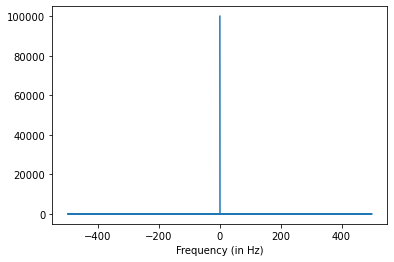

In [22]:
y_ft = scp.fft.fft(y_dc)
freqs = scp.fft.fftfreq(x1.shape[-1])*samp_rate
plt.plot(freqs, abs(y_ft.real))
plt.xlabel('Frequency (in Hz)')
peaks=scp.signal.find_peaks(y_ft.real)
peak_vals = peaks[0][:len(peaks[0])//2]/dur
print('Peaks at:',peak_vals)

A constant term is equivalent to a sine wave with 0 frequency hence the presence of a very large spike at that position.

While the other peaks can still be found, the constant term can affect stationarity and other statistics we may want to measure later on. To remove this constant term, we can process the coefficients of the Fourier transform to remove it.

Peaks at: [ 5. 10.]


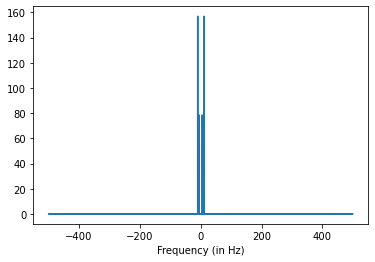

In [23]:
y_ft = scp.fft.fft(y_dc)
y_ft[0]=0 #We set the 0'th frequency term to 0
freqs = scp.fft.fftfreq(x1.shape[-1])*samp_rate
plt.plot(freqs, abs(y_ft.real))
plt.xlabel('Frequency (in Hz)')
peaks=scp.signal.find_peaks(y_ft.real,threshold=0)
peak_vals = peaks[0][:len(peaks[0])//2]/dur
print('Peaks at:',peak_vals)

After setting the coefficient for the 0 frequency waves to 0, we eliminate the constant term. By performing the IFT, we can retrieve the original mixed signal with frequencies of 5 and 10.

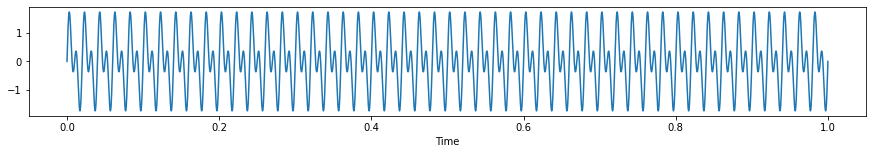

In [24]:
plt.subplots(figsize=(15,2))
plt.plot(np.arange(0,1,1/(len(y_ft))),scp.fft.ifft(y_ft).real)
plt.xlabel('Time');

Admittedly, this is a fairly poor example as we can simply deduct the sample mean from the entire sample to achieve the same result making the need for FT and IFT moot. We will tackle more complicated uses down the line.

## Noise Filtering

Real time series data are never free from noise making it tricky to find the real dynamics of whatever it is measuring. We may end up trying to model noise and end up overlooking the real behavior of the time series.


Thankfully, we can manipulate time series data in the frequency domain to eliminate one of the most types of noise - white noise. White noise pervades time series data and by definition, has components across all frequencies. Usually, a time series with white noise is represented as:

\begin{align} X(t) = s(t) + v(t) \end{align}

where $s(t)$ is the true signal we want to retrieve from $X(t)$ and $v(t)$ is white noise we want to eliminate. We simulate this below by adding a uniform random noise to the signal.

### Filtering by Energy Level

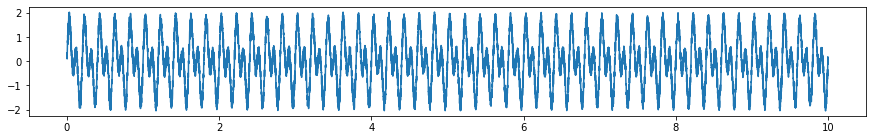

In [25]:
noise = np.random.uniform(-.3,.3,len(y))
y_noisy = y+noise
plt.subplots(figsize=(15,2))
plt.plot(x1,y_noisy);

The resulting FT of the noisy signal results in multiple peaks being found. This poses a problem if we are trying to find the appropriate periodic trends in our data.

Peaks at: [2.000e-01 5.000e-01 9.000e-01 ... 4.994e+02 4.996e+02 4.999e+02]


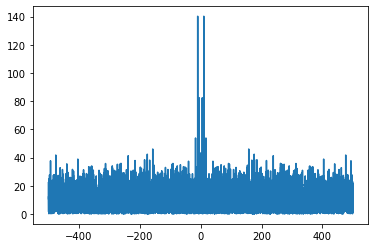

In [26]:
y_ft = scp.fft.fft(y_noisy)
freqs = scp.fft.fftfreq(x1.shape[-1])*samp_rate
plt.plot(freqs, abs(y_ft.real))
peaks=scp.signal.find_peaks(y_ft.real)
peak_vals = peaks[0][:len(peaks[0])//2]/dur
print('Peaks at:',peak_vals);

In crude fashion, we can set a hard threshold wherein that makes coefficients of frequencies below a certain "energy" level 0. One way to accomplish this is by setting the cut-off as a multiple of the standard deviation.

\textit{Conversely, we can perform the same method to eliminate high energy signals or even select those in a certain band}  

In [27]:
threshold = 3*np.std(y_ft.real);
peaks=scp.signal.find_peaks(y_ft.real, threshold=threshold)
peak_vals = peaks[0][:len(peaks[0])//2]/dur
print('Peaks at:',peak_vals);

Peaks at: [  5.    5.2  10.  146.  157.7 175.6 202.  228.1 238.3 244.  357.4 385.2
 400.1]


By visual inspeciton and setting a threshold of 3x the standard deviaiton, we are able to retrieve a clear signal of the dominant frequencies.

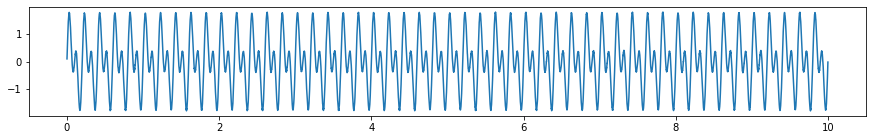

In [28]:
y_ft_denoised = [0 if x<threshold else x for x in y_ft] #Threshold by observation
plt.subplots(figsize=(15,2))
y_denoised = scp.fft.ifft(y_ft_denoised)
plt.plot(x1,y_denoised.real);

After threhsold, look at 1-2 std of mean of filtered new signal.

### Filtering by Frequency

Suppose that our measurement was performed in an environment wherein there is the presence of an external high frequency signal. We would want to retrieve the lower frequencies only because that is what is relevant to our study. 

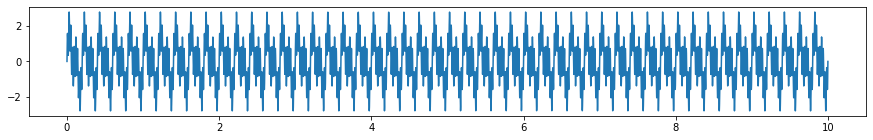

In [29]:
hf_noise = sine_wave(amp, 45, samp_rate, dur, plot=False)[1]
y_hf_noisy = y+hf_noise
plt.subplots(figsize=(15,2))
plt.plot(x,y_hf_noisy);

Peaks at: [ 5. 10. 45.]


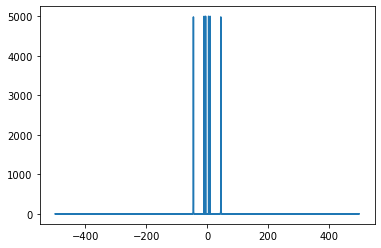

In [30]:
y_ft_hf = scp.fft.fft(y_hf_noisy)
freqs = scp.fft.fftfreq(x.shape[-1])*samp_rate
plt.plot(freqs, abs(y_ft_hf))
peaks=scp.signal.find_peaks(y_ft_hf.real)
peak_vals = peaks[0][:len(peaks[0])//2]/dur
print('Peaks at:',peak_vals);

By observing the coefficients of the FT, we can eliminate frequencies that are higher than a specific frequency $f_{thresh}$. And thus retrieve the original signal.

\textit{Conversely, we can do the same for low frequencies and those in a "band".} 

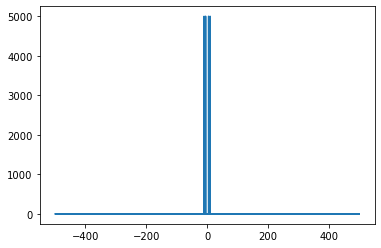

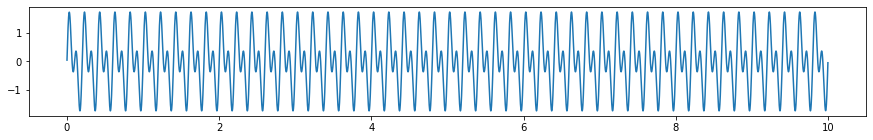

In [31]:
f_thresh = 20

W = scp.fft.fftfreq(x.shape[-1], d=1/samp_rate)
y_ft_hf_copy = y_ft_hf.copy()
y_ft_hf_copy[(abs(W)>f_thresh)] = 0

freqs = scp.fft.fftfreq(x.shape[-1])*samp_rate
plt.plot(freqs, abs(y_ft_hf_copy))
plt.show()
peaks=scp.signal.find_peaks(y_ft.real)

y_lf = scp.fft.ifft(y_ft_hf_copy)
plt.subplots(figsize=(15,2))
plt.plot(x,y_lf.real);

### Jena Climate Data

Looking at climate information, we can glean insights into the seasonality of climate patterns. Let's examine the mean daily temperature of the Jena climate dataset and apply FT to examine its seasonality.

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


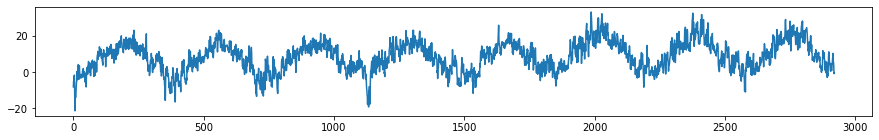

In [32]:
df = pd.read_csv('../data/fft/Jena.csv')
display(df.head())
df['Date Time'] = pd.to_datetime(df['Date Time'], dayfirst=True, format="%d.%m.%Y %H:%M:%S")
df['Date'] = df['Date Time'].dt.date
mean_temps = df.groupby('Date')['T (degC)'].mean().values
plt.subplots(figsize=(15,2))
plt.plot(temp);

There is a very strong trend that can be seen every year. Suppose we want to examine trends that happen within the years, we filter out the frequency corresponding to 1 year by setting its magnitude to 0.

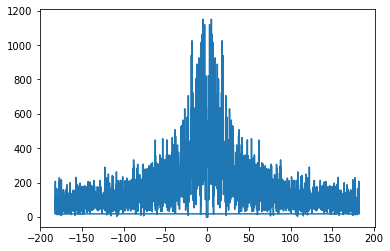

In [33]:
y_ft = scp.fft.fft(temp.values)
y_ft_copy = y_ft.copy()
freqs = scp.fft.fftfreq(len(temp), d=1/365)
y_ft_copy[(abs(freqs)<=1)] = 0
plt.plot(freqs,abs(y_ft_copy));

By removing all frequencies below 1 year, we obtain only the higher frequency values. With these values, we can have a better look at the sub-year dynamics of daily temperature.

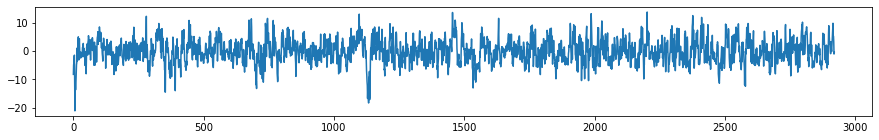

In [34]:
y_hf = scp.fft.ifft(y_ft_copy)
plt.subplots(figsize=(15,2))
# plt.title('Removing Yearly Cycle')
plt.plot(range(len(temp)),y_hf.real);

### Quick exploration:
    1. What other strategies can we adopt to filter signals from very noisy measurements?

    2. What other real world examples of noise have you experienced? How did you deal with them?

    3. How can applying these frequency domain applications improve time series predictions?

## Wavelet Transform

A wavelet transform (WT) allows you to measure how "much"of a certain type of wavelet there exists in a given signal. A key difference between a WT and an FT is that a WT gives you information about the time domain and not just in the frequency domain.

This transformation is achieved by taking a wavelet with specified properties and sliding it across the entire signal both through time and through different scales to find where it matches with the signal.

In [35]:
def rescale(arr, factor=2):
    n = len(arr)
    return np.interp(np.linspace(0, n, factor*n+1), np.arange(n), arr)

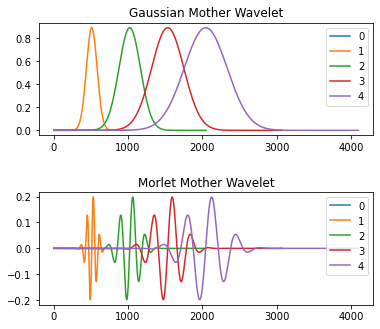

In [36]:
fig, ax = plt.subplots(nrows = 2)
wav1 = pywt.ContinuousWavelet('gaus1')
wav2 = pywt.ContinuousWavelet('morl')
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)
int_psi1, x = pywt.integrate_wavelet(wav1, precision=10)
int_psi2, x = pywt.integrate_wavelet(wav2, precision=10)

for s in range(5):
    ax[0].plot(rescale(int_psi1, factor=s),label=s)
    ax[0].legend()
    ax[0].set_title('Gaussian Mother Wavelet')
    ax[1].plot(rescale(int_psi2, factor=s),label=s)
    ax[1].set_title('Morlet Mother Wavelet');
    ax[1].legend()

The wavelet transform of a time series X(t) is given by:

\begin{align} CWT(X(t)) = \frac{1}{\sqrt{|\sigma|}}\int_{-\infty}^{\infty}X(t)\psi(\frac{t-S}{\sigma})dt \end{align}

where $\sigma$ is the scale, $s$ is the time lag/translation, and $\psi$ is the "mother" wavelet. 

The scaling transformation applied on the mother wavelet can be thought of as "stretching" it only without changing its frequency.

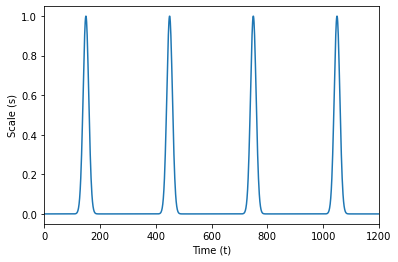

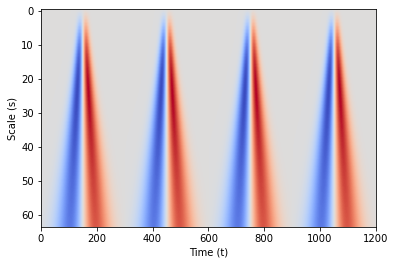

In [37]:
s1 = list(scp.signal.gaussian(300, std=10))
s1 = np.tile(s1,4)
plt.xlim(left=0,right=1200)
plt.ylabel('Scale (s)')
plt.xlabel('Time (t)')
plt.plot(s1)
plt.show();
coeffs, freqs = pywt.cwt(s1,range(1, 65),wavelet='gaus1')
plt.xlim(left=0,right=1200)
plt.ylabel('Scale (s)')
plt.xlabel('Time (t)')
plt.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto');

Interpreting these results, we see the presence of gaussian waves across times and scales.

The Morlet wavelet is commonly used on signals which have sinusoidal patterns. It is important to know when to use which mother wavelet on a signal as they will give rise to different results.

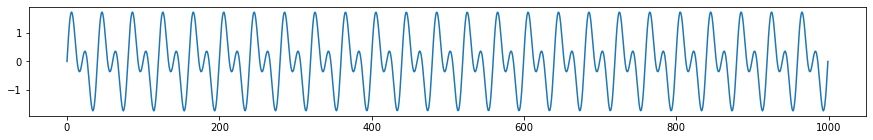

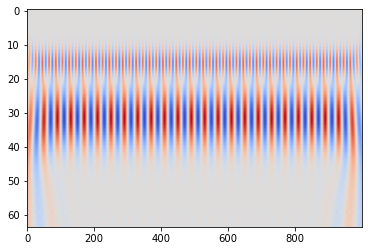

In [38]:
sine5 = sine_wave(freq=5,plot=False)[1]
sine10 = sine_wave(freq=10,plot=False)[1]
sine_5_10 = sine5+sine10
plt.subplots(figsize=(15,2))
plt.plot(sine_5_10)
plt.show()
coeffs, freqs = pywt.cwt(sine5+sine10,range(1, 65),wavelet='morl')
plt.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto');

By using the Morlet mother wavelet, we can clearly see two bands with different scales across time.

However, if we were to apply a Gaussian mother wavelet for its WT, we get less clear results.

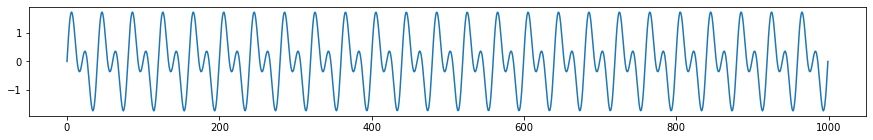

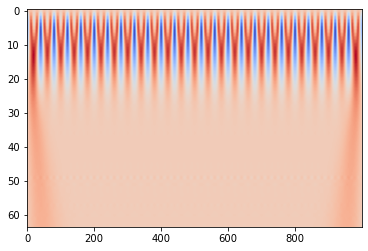

In [39]:
sine5 = sine_wave(freq=5,plot=False)[1]
sine10 = sine_wave(freq=10,plot=False)[1]
sine_5_10 = sine5+sine10
plt.subplots(figsize=(15,2))
plt.plot(sine_5_10)
plt.show()
coeffs, freqs = pywt.cwt(sine5+sine10,range(1, 65),wavelet='gaus1')
plt.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto');

## Using Accelerometer and Gyroscopic Data

The following code is taken from:

https://towardsdatascience.com/multiple-time-series-classification-by-using-continuous-wavelet-transformation-d29df97c0442

In [40]:
def load_y_data(y_path):
    y = np.loadtxt(y_path, dtype=np.int32).reshape(-1,1)
    # change labels range from 1-6 t 0-5, this enables a sparse_categorical_crossentropy loss function
    return y - 1

def load_X_data(X_path):
    X_signal_paths = [X_path + file for file in os.listdir(X_path)]
    X_signals = [np.loadtxt(path, dtype=np.float32) for path in X_signal_paths]
    return np.transpose(np.array(X_signals), (1, 2, 0))

PATH = '../data/cwt/'
LABEL_NAMES = ["Walking", "Walking upstairs", "Walking downstairs", "Sitting", "Standing", "Laying"]

# load X data
X_train = load_X_data(PATH + 'train/Inertial Signals/')
X_test = load_X_data(PATH + 'test/Inertial Signals/')
# load y label
y_train = load_y_data(PATH + 'train/y_train.txt')
y_test = load_y_data(PATH + 'test/y_test.txt')

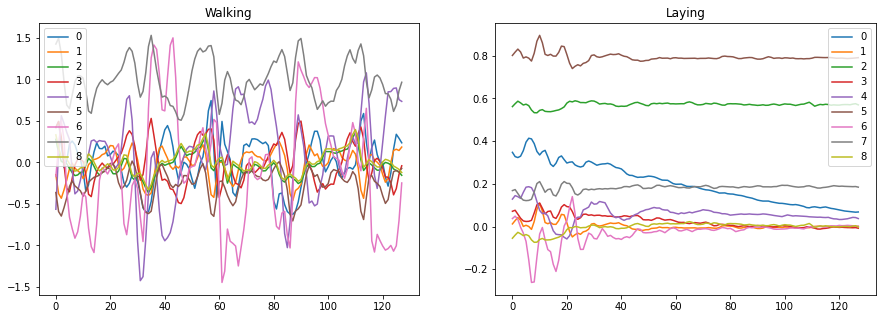

In [41]:
fig, ax = plt.subplots(ncols=2,figsize=(15,5))
pd.DataFrame(X_train[79]).plot(ax=ax[0],title='Walking');
pd.DataFrame(X_train[51]).plot(ax=ax[1],title='Laying');

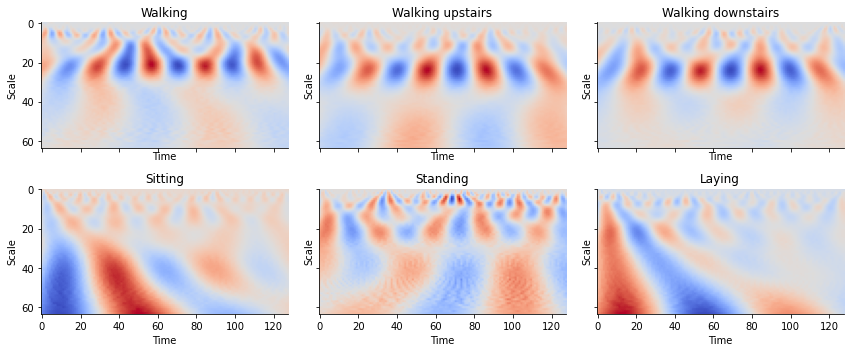

In [42]:
def split_indices_per_label(y):
    indicies_per_label = [[] for x in range(0,6)]
    # loop over the six labels
    for i in range(6): 
        indicies_per_label[i] = np.where(y == i)[0]
    return indicies_per_label

def plot_cwt_coeffs_per_label(X, label_indicies, label_names, signal, sample, scales, wavelet):
    
    fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(12,5))
    
    for ax, indices, name in zip(axs.flat, label_indicies, label_names):
        coeffs, freqs = pywt.cwt(X[indices[sample],:, signal], scales, wavelet = wavelet)
        ax.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')
        ax.set_title(name)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel('Scale')
        ax.set_xlabel('Time')
    plt.tight_layout()

train_labels_indicies = split_indices_per_label(y_train)

#signal indicies: 0 = body acc x, 1 = body acc y, 2 = body acc z, 3 = body gyro x, 4 = body gyro y, 5 = body gyro z, 6 = total acc x, 7 = total acc y, 8 = total acc z
signal = 3 # signal index
sample = 1 # sample index of each label indicies list
scales = np.arange(1, 65) # range of scales
wavelet = 'morl' # mother wavelet

plot_cwt_coeffs_per_label(X_train, train_labels_indicies, LABEL_NAMES, signal,
                          sample, scales, wavelet)

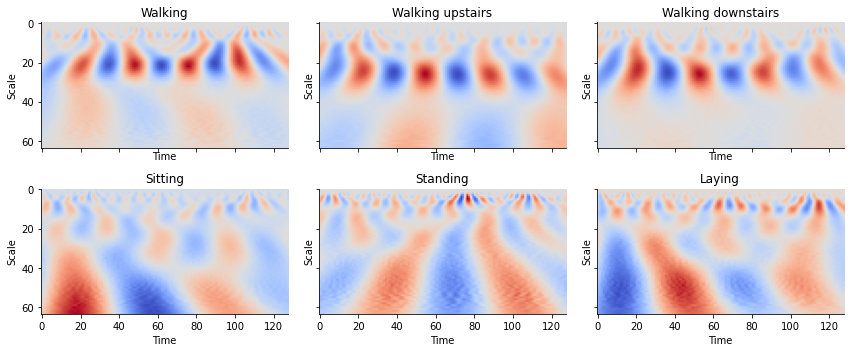

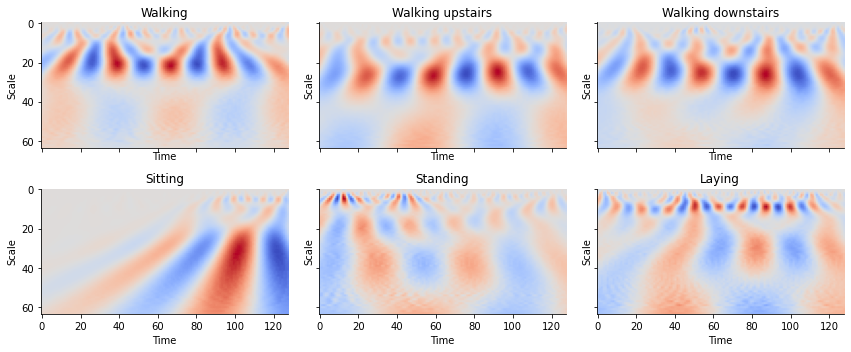

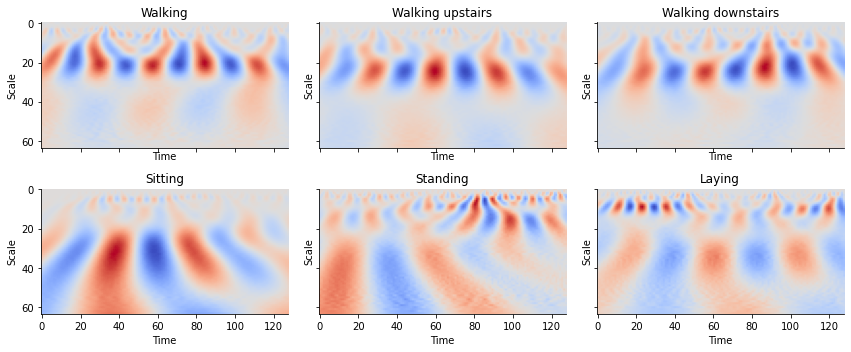

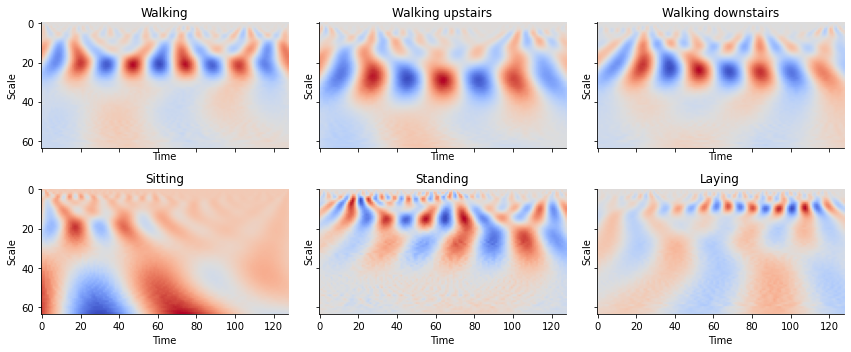

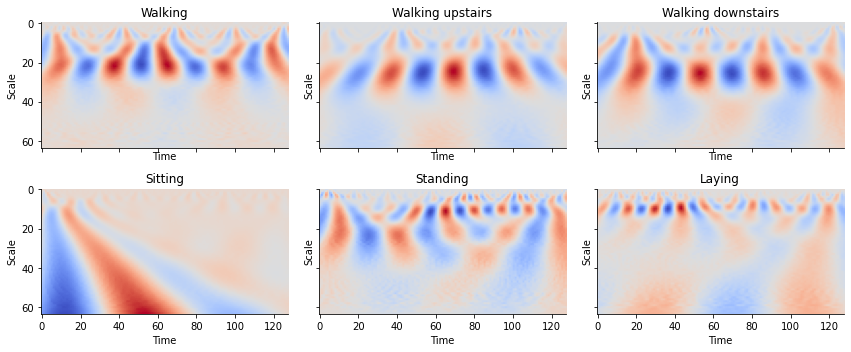

In [43]:
for sample in range(2,7):
    plot_cwt_coeffs_per_label(X_train, train_labels_indicies, LABEL_NAMES,
                              signal, sample, scales, wavelet)

Looking at the plots for each activity, we see can see some patterns between the images. By feeding these results into a convolutional neural network, we can create a classifier to classify time series into activities.

## Conclusion

To summarize, using these techniques can extract valuable information about time series which are not readily available.

Cross-correlations can give insights into the sychronicity of data. With careful analysis, these can even be used as a step towards a more holistic view of causality in conjunction with Granget Causality.

Fourier Transformation allows us to view the time series in the frequency domain, allowing operations previously untenable in the time domain. Filtering is a common task where FT is useful as it lets us easily manipulate the data to remove noise or highlight aspects of interest within the time series.


Wavelet Transformation lets us decompose time series more finely than the FT since we can define the "mother" wavelet to be our wavefunction of interest. By characterizing time series, we can quite literally, paint a picture of the time series that can be used to pick out specific waveforms in the time series.

In the context of forecasting, all three techniques can be used to inform the modeler how to prepare their data. With cross-correlations, the best time lagged time series can be used to provide better information about the target. The Fourier Transform can be applied to denoise the data and remove certain trends. Wavelet Transforms can be used to classify time series allowing the modeler to include their classification as a feature for forecasting or creating separate models for each class of time series.

The following chapter represents the culmination of all the forecasting concepts from previous sections. There is no better way to test your time series capabilities than with a competition. The next chapter discusses the best techniques which were utilized in the recently concluded M5 Competition. In it, the best models under some constraints, are pushed to the limit to perform time series forecasting.